In [1]:
# 1. 导入必要的库
import numpy as np
import pandas as pd
import keras # 深度学习框架
import ml_edu.experiment # Google 课程专用的实验工具
import ml_edu.results    # Google 课程专用的结果展示工具
import plotly.express as px # 交互式绘图工具

# 2. 设置 Pandas 显示选项
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("✅ 库导入成功！")

# 3. 加载数据集
print("正在下载并读取数据...")
chicago_taxi_dataset = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/chicago_taxi_train.csv")

print("✅ 数据集加载成功！")

✅ 库导入成功！
正在下载并读取数据...
✅ 数据集加载成功！


In [2]:
# --- 第3步：筛选我们需要的列 ---
# 我们只保留：里程、时长、车费、公司、支付方式、小费率
training_df = chicago_taxi_dataset.loc[:, ('TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'COMPANY', 'PAYMENT_TYPE', 'TIP_RATE')]

print('数据清洗完成。')
print('总行数: {0}'.format(len(training_df.index)))

# 显示前 10 行数据看看长什么样
training_df.head(10)

数据清洗完成。
总行数: 31694


,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
0,2.6,2341,32.0,Flash Cab,Mobile,6.3
1,1.2,1074,9.8,Flash Cab,Credit Card,27.9
2,1.3,1173,10.2,Sun Taxi,Cash,0.0
3,3.7,3360,23.8,Choice Taxi Association,Cash,0.0
4,1.1,1044,10.0,Flash Cab,Cash,0.0
5,1.4,1251,11.0,Flash Cab,Credit Card,27.3
6,2.0,1813,14.5,Sun Taxi,Cash,0.0
7,2.0,1857,14.8,Sun Taxi,Credit Card,25.8
8,0.9,787,8.0,City Service,Cash,0.0
9,1.6,1399,17.9,Flash Cab,Mobile,23.0


In [3]:
# --- 第4步：查看统计数据 ---
# describe() 函数会帮我们算好平均值(mean)、标准差(std)、最大值(max)等
training_df.describe(include='all')

,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
count,31694.0,31694.0,31694.0,31694,31694,31694.0
unique,NaN,NaN,NaN,31,7,NaN
top,NaN,NaN,NaN,Flash Cab,Credit Card,NaN
freq,NaN,NaN,NaN,7887,14142,NaN
mean,8.3,1319.8,23.9,NaN,NaN,13.0
...,...,...,...,...,...,...
min,0.5,60.0,3.2,NaN,NaN,0.0
25%,1.7,548.0,9.0,NaN,NaN,0.0
50%,5.9,1081.0,18.8,NaN,NaN,12.2
75%,14.5,1888.0,38.8,NaN,NaN,20.8


In [4]:
# --- 第5步：查看相关性矩阵 ---
# 这一步是为了找出谁跟“车费(FARE)”的关系最铁
# 1.0 = 完美正相关 (比如里程越长，车费越贵)
# 0.0 = 毫无关系
training_df.corr(numeric_only = True)

,TRIP_MILES,TRIP_SECONDS,FARE,TIP_RATE
TRIP_MILES,1.0,0.8,1.0,-0.0
TRIP_SECONDS,0.8,1.0,0.8,-0.1
FARE,1.0,0.8,1.0,-0.1
TIP_RATE,-0.0,-0.1,-0.1,1.0


In [5]:
# --- 第6步：可视化数据关系 ---
# 画一个散点图矩阵，直观地看看数据长什么样
# 这是一个交互式图表，你可以把鼠标放上去看具体数值
px.scatter_matrix(training_df, dimensions=["FARE", "TRIP_MILES", "TRIP_SECONDS"])

In [6]:
# --- 第7步：定义机器学习函数 (核心引擎) ---

def create_model(
    settings: ml_edu.experiment.ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """创建一个简单的线性回归模型"""
  
  # 定义输入层：根据我们选的特征数量来定
  inputs = {name: keras.Input(shape=(1,), name=name) for name in settings.input_features}
  
  # 如果有多个特征，把它们拼起来；如果只有一个，这步也没影响
  concatenated_inputs = keras.layers.Concatenate()(list(inputs.values()))
  
  # 定义输出层：只有一个神经元 (Dense layer)，因为它只需要输出一个数字（预测的车费）
  outputs = keras.layers.Dense(units=1)(concatenated_inputs)
  
  # 组装模型
  model = keras.Model(inputs=inputs, outputs=outputs)

  # 编译模型：告诉它用什么方法来学习 (RMSprop) 以及怎么判断学得好不好 (均方误差 MSE)
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=settings.learning_rate),
                loss="mean_squared_error",
                metrics=metrics)

  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    label_name: str,
    settings: ml_edu.experiment.ExperimentSettings,
) -> ml_edu.experiment.Experiment:
  """开始训练模型"""

  # 准备好饲料：特征数据
  features = {name: dataset[name].values for name in settings.input_features}
  # 准备好答案：标签数据 (车费)
  label = dataset[label_name].values

  # Let's Go! 开始训练
  # epochs: 也就是让模型把所有数据复习几遍
  history = model.fit(x=features,
                      y=label,
                      batch_size=settings.batch_size,
                      epochs=settings.number_epochs)

  # 打包返回训练结果
  return ml_edu.experiment.Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )

print("✅ 成功：机器学习函数定义完成！")

✅ 成功：机器学习函数定义完成！


2026-01-11 23:31:16.470960: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2026-01-11 23:31:16.471058: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-01-11 23:31:16.471074: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2026-01-11 23:31:16.471337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-11 23:31:16.471355: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2026-01-11 23:31:17.137058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 75.4333 - rmse: 8.6852  
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 23.0059 - rmse: 4.7965
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 19.3385 - rmse: 4.3976
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 17.7490 - rmse: 4.2130
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 16.4458 - rmse: 4.0553
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 15.4840 - rmse: 3.9350
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.8160 - rmse: 3.8492
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.4106 - rmse: 3.7961
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.2008 - rmse: 3.7684
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.1074 - rmse: 3.7560
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.0650 - rmse: 3.7503
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.0457 - rmse: 3.7478
Epoch 13/2

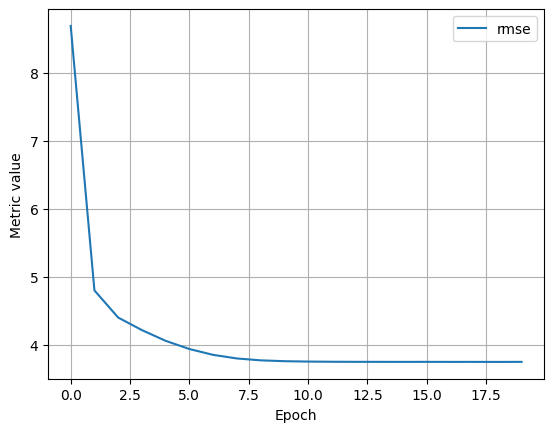

In [7]:
# --- 第8步：实验 1 (单特征训练) ---

# 1. 设置“超参数” (Hyperparameters)
# 这些就像是调节收音机的旋钮，决定了学习的效率
settings_1 = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,  # 学习率：步子迈多大？
    number_epochs = 20,     # 轮数：把数据复习 20 遍
    batch_size = 50,        # 批大小：一次看 50 道题再改答案
    input_features = ['TRIP_MILES'] # 只看里程
)

# 2. 告诉模型我们要用 RMSE (均方根误差) 来评分
# 简单说：RMSE 越小，预测越准
metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

# 3. 创建模型
model_1 = create_model(settings_1, metrics)

# 4. 开始训练！(这时候 GPU 才会动一下)
experiment_1 = train_model('one_feature', model_1, training_df, 'FARE', settings_1)

# 5. 画图看看结果
# 第一张图：学习曲线 (Loss Curve) - 应该是一条往下降的线
ml_edu.results.plot_experiment_metrics(experiment_1, ['rmse'])

# 第二张图：预测结果对比 - 看看模型画的线准不准
ml_edu.results.plot_model_predictions(experiment_1, training_df, 'FARE')

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 48.9630 - rmse: 5.6123
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 48.4918 - rmse: 6.9636
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 48.1606 - rmse: 6.9398
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 48.3496 - rmse: 6.9534
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 48.3488 - rmse: 6.9533
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 47.9492 - rmse: 6.9245
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 47.9661 - rmse: 6.9258
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 48.4120 - rmse: 6.9579
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 48.2577 - rmse: 6.9468
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 47.2744 - rmse: 6.8756
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 47.1422 - rmse: 6.8660
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 47.4850 - rmse: 6.8909
E

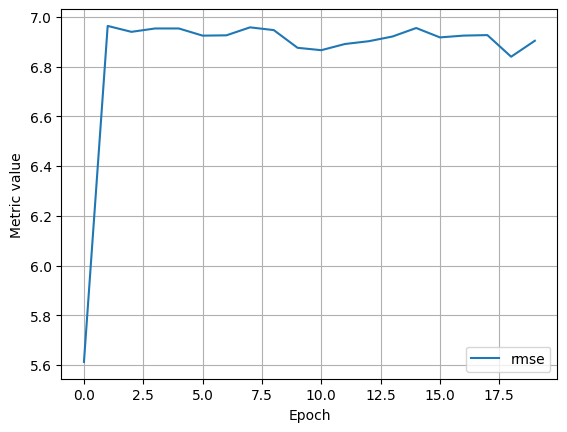

In [9]:
# --- 第9步：实验 A (学习率过大) ---
# 修正版：必须用 1.0 (float) 而不是 1 (int)

settings_high_lr = ml_edu.experiment.ExperimentSettings(
    learning_rate = 1.0,  # ✅ 改成 1.0 就没问题了
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MILES']
)

model_high_lr = create_model(settings_high_lr, metrics)

experiment_high_lr = train_model('high_learning_rate', model_high_lr, training_df, 'FARE', settings_high_lr)

ml_edu.results.plot_experiment_metrics(experiment_high_lr, ['rmse'])

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 318.5665 - rmse: 13.5320
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 293.6389 - rmse: 17.1359
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 269.9272 - rmse: 16.4295
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 247.2162 - rmse: 15.7231
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 225.5434 - rmse: 15.0181
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 205.0632 - rmse: 14.3200
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 185.4530 - rmse: 13.6181
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 167.1475 - rmse: 12.9286
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 149.8280 - rmse: 12.2404
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 133.5500 - rmse: 11.5564
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 118.5107 - rmse: 10.8863
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10

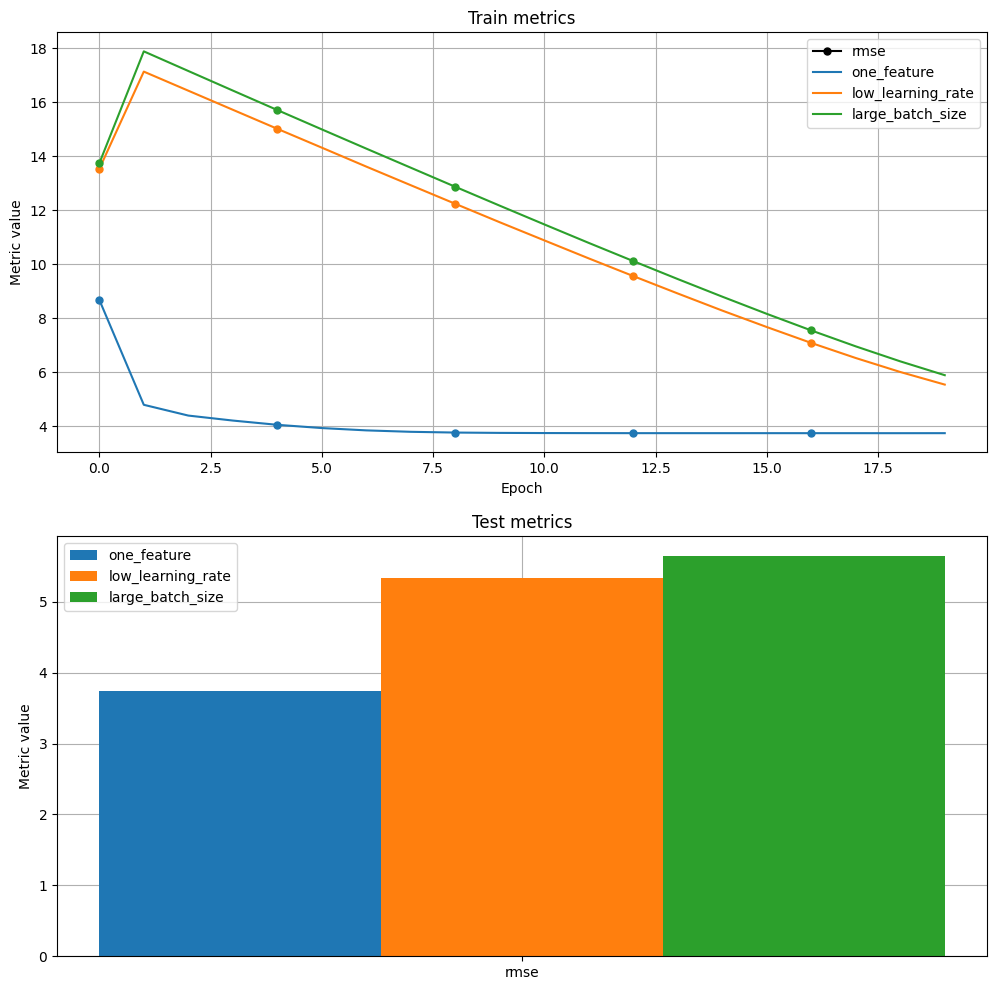

In [10]:
# --- 第10步：实验 B (学习率过小) ---
# 我们把 learning_rate 设得特别小 (0.0001)，看看它是怎么“磨洋工”的
settings_low_lr = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.0001, # 🐢 蜗牛速度
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MILES']
)
model_low_lr = create_model(settings_low_lr, metrics)
experiment_low_lr = train_model('low_learning_rate', model_low_lr, training_df, 'FARE', settings_low_lr)

# --- 第11步：实验 C (批次过大) ---
# 学习率恢复正常 (0.001)，但是一次要看 500 个数据才改一次答案
settings_large_batch = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,
    number_epochs = 20,
    batch_size = 500, # 🐘 囫囵吞枣
    input_features = ['TRIP_MILES']
)
model_large_batch = create_model(settings_large_batch, metrics)
experiment_large_batch = train_model('large_batch_size', model_large_batch, training_df, 'FARE', settings_large_batch)

# --- 画图对比 ---
# 我们把“正常版”、“蜗牛版”、“大胃王版”放一起对比
print("正在绘制对比图...")
ml_edu.results.compare_experiment(
    [experiment_1, experiment_low_lr, experiment_large_batch],
    ['rmse'],
    training_df,
    training_df['FARE'].values
)

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 62.1022 - rmse: 6.8533 
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 23.0228 - rmse: 4.7982
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 16.8164 - rmse: 4.1008
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.5697 - rmse: 3.8170
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 13.5558 - rmse: 3.6818
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.9554 - rmse: 3.5994
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 12.5707 - rmse: 3.5455
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.3314 - rmse: 3.5116
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 12.2069 - rmse: 3.4938
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12.1469 - rmse: 3.4852
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12.1217 - rmse: 3.4816
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12.1048 - rmse: 3.4792


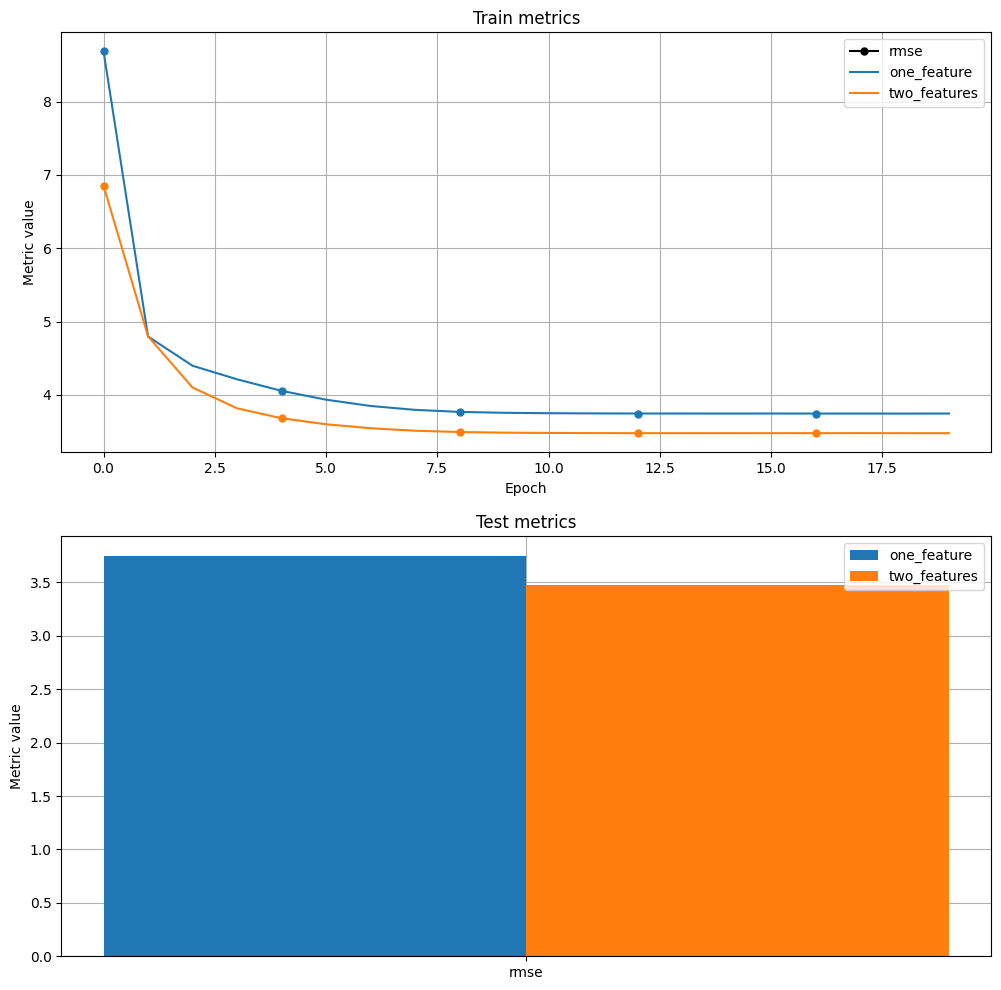

In [11]:
# --- 第12步：实验 3 (双特征模型) ---
# 我们同时使用 'TRIP_MILES' 和 'TRIP_MINUTES' 来训练

# 1. 准备数据：因为原数据只有“秒”，我们把它换算成“分钟”
training_df['TRIP_MINUTES'] = training_df['TRIP_SECONDS'] / 60

# 2. 设置参数 (用回刚才那个表现最好的参数)
settings_3 = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MILES', 'TRIP_MINUTES'] # ✅ 双特征
)

# 3. 创建并训练模型
model_3 = create_model(settings_3, metrics)
experiment_3 = train_model('two_features', model_3, training_df, 'FARE', settings_3)

# 4. 画图：这次我们要对比“单特征”和“双特征”谁更强
print("正在对比单特征 vs 双特征...")
ml_edu.results.compare_experiment(
    [experiment_1, experiment_3], 
    ['rmse'], 
    training_df, 
    training_df['FARE'].values
)

In [12]:
# --- 第13步：最终验收 (预测演示) ---

# 定义几个辅助函数，把预测结果打印得好看点
def format_currency(x):
  return "${:.2f}".format(x)

def predict_fare(model, df, features, label, batch_size=50):
  # 随机抽取 50 条数据
  batch = df.sample(n=batch_size).copy()
  batch.reset_index(drop=True, inplace=True) # 重置索引
  
  # 让模型进行预测
  predicted_values = model.predict(x={name: batch[name].values for name in features})

  # 整理结果：把预测值、真实值、误差都列出来
  data = {"PREDICTED_FARE": [], "OBSERVED_FARE": [], "L1_LOSS": [],
          features[0]: [], features[1]: []}
  
  for i in range(batch_size):
    predicted = predicted_values[i][0]
    observed = batch.at[i, label]
    data["PREDICTED_FARE"].append(format_currency(predicted))
    data["OBSERVED_FARE"].append(format_currency(observed))
    data["L1_LOSS"].append(format_currency(abs(observed - predicted))) # L1 Loss 就是绝对误差
    data[features[0]].append(batch.at[i, features[0]])
    data[features[1]].append("{:.2f}".format(batch.at[i, features[1]]))

  return pd.DataFrame(data)

# 使用刚才那个表现最好的“双特征模型” (experiment_3) 来预测
output = predict_fare(model_3, training_df, settings_3.input_features, 'FARE')

# 打印表头
print("-" * 80)
print("|" + "PREDICTIONS (预测结果对比)".center(78) + "|")
print("-" * 80)
# 显示前 10 条预测结果
print(output.head(10))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
--------------------------------------------------------------------------------
|                             PREDICTIONS (预测结果对比)                             |
--------------------------------------------------------------------------------
  PREDICTED_FARE OBSERVED_FARE L1_LOSS  TRIP_MILES TRIP_MINUTES
0          $7.68         $7.50   $0.18         1.0        12.33
1         $54.68        $57.53   $2.85        22.9        30.23
2         $22.76        $23.75   $0.99         6.8        34.92
3         $28.27        $29.50   $1.23         8.9        42.58
4          $7.80         $7.00   $0.80         1.3         9.40
5         $43.54        $42.75   $0.79        17.1        34.00
6         $38.27        $37.75   $0.52        14.6        32.67
7         $59.48        $58.00   $1.48        22.9        61.67
8          $9.90        $10.65   $0.75         2.1        11.55
9         $42.00        $41.75   $0.25        17.0        24.98


In [13]:
# --- 性能优化实验：喂饱你的 GPU ---

# 1. 暴力参数设置
settings_speed = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.05,   # 批次大了，步子也要迈大一点，不然学得慢
    number_epochs = 50,     # 多跑几轮，反正很快
    batch_size = 2048,      # ⚡️ 核心：一次喂 2048 条数据！
    input_features = ['TRIP_MILES', 'TRIP_MINUTES']
)

print(f"🔥 开始极速训练 (Batch Size: {settings_speed.batch_size})...")

# 2. 创建并训练
model_speed = create_model(settings_speed, metrics)

# 这里的 verbose=1 会显示进度条，注意观察每一步的时间 (ms/step)
experiment_speed = train_model('speed_test', model_speed, training_df, 'FARE', settings_speed)

print("训练完成！感受一下速度。")

🔥 开始极速训练 (Batch Size: 2048)...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 96.3834 - rmse: 7.3644 
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 45.4248 - rmse: 6.7398
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26.7606 - rmse: 5.1731
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.2208 - rmse: 4.1498
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.8683 - rmse: 3.8559
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.6570 - rmse: 3.6955
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.4598 - rmse: 3.6688
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.2904 - rmse: 3.6456
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.1693 - rmse: 3.6289
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.9504 - rmse: 3.5987
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.0748 - rmse: 3.6159
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.9879 - rmse:

In [14]:
# --- 进阶 1：保存模型 ---

# 把我们表现最好的 model_3 保存成一个 .keras 文件
# 这样它就会以文件的形式存在你的硬盘上
model_3.save('my_taxi_model.keras')

print("✅ 模型已保存为 'my_taxi_model.keras'")
print("下次使用时，只需要用 keras.models.load_model('my_taxi_model.keras') 就能找回它。")

✅ 模型已保存为 'my_taxi_model.keras'
下次使用时，只需要用 keras.models.load_model('my_taxi_model.keras') 就能找回它。


🚀 启动深度神经网络训练...
Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 117.0912 - rmse: 8.0612
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.9313 - rmse: 4.2345
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.5755 - rmse: 3.6845
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.5798 - rmse: 3.5468
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.2933 - rmse: 3.5062
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.1944 - rmse: 3.4920
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.2021 - rmse: 3.4931
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.1566 - rmse: 3.4866
Epoch 9/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.1884 - rmse: 3.4912
Epoch 10/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.2416 - rmse: 3.4988
Epoch 11/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.2095 - rmse: 3.4942
Epoch 12/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.1401 - rmse: 3.4843
Epoch 1

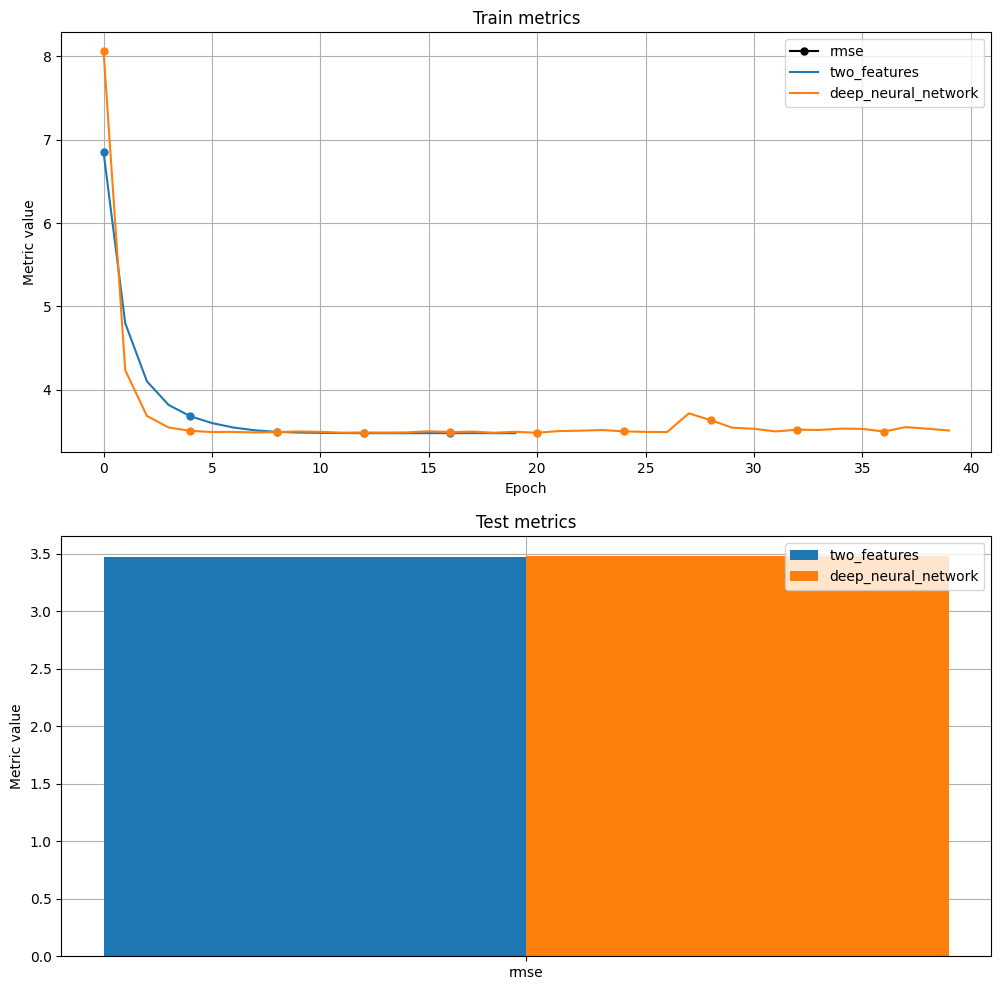

In [15]:
# --- 进阶 2：挑战深度神经网络 (DNN) ---

def create_deep_model(settings, metrics):
    """创建一个'深'一点的模型，而不只是线性回归"""
    
    inputs = {name: keras.Input(shape=(1,), name=name) for name in settings.input_features}
    concatenated = keras.layers.Concatenate()(list(inputs.values()))
    
    # --- 核心区别在这里 ---
    # 我们不直接输出，而是先通过两个“隐藏层”
    # Dense(32): 这一层有 32 个神经元
    # activation='relu': 激活函数，让模型学会“拐弯” (非线性关系)
    x = keras.layers.Dense(32, activation='relu')(concatenated)
    x = keras.layers.Dense(32, activation='relu')(x)
    
    # 最后输出预测价格
    outputs = keras.layers.Dense(1)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # 使用 Adam 优化器 (比 RMSprop 更智能一点，是现在的各种大模型的标配)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=settings.learning_rate),
                  loss="mean_squared_error",
                  metrics=metrics)
    
    return model

# 1. 设置参数 (我们用大 Batch Size，让 M4 Pro 跑得爽一点)
settings_deep = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.01,   # 深度模型有时候需要调整学习率
    number_epochs = 40,     # 多学几轮，因为它结构更复杂
    batch_size = 1000,
    input_features = ['TRIP_MILES', 'TRIP_MINUTES']
)

# 2. 创建并训练深度模型
print("🚀 启动深度神经网络训练...")
model_deep = create_deep_model(settings_deep, metrics)
experiment_deep = train_model('deep_neural_network', model_deep, training_df, 'FARE', settings_deep)

# 3. 终极对决：线性 vs 深度
print("\n🥊 终极对决：线性回归 (Linear) vs 深度学习 (Deep)")
ml_edu.results.compare_experiment(
    [experiment_3, experiment_deep], 
    ['rmse'], 
    training_df, 
    training_df['FARE'].values
)

🔧 正在以更稳健的参数重新训练 DNN...
Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 322.1561 - rmse: 12.9279
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 55.9271 - rmse: 7.4784
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 45.6287 - rmse: 6.7549
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 37.0557 - rmse: 6.0873
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 29.3227 - rmse: 5.4150
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 21.0272 - rmse: 4.5855
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.6287 - rmse: 4.0778
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.1174 - rmse: 3.8881
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.5814 - rmse: 3.8186
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.2450 - rmse: 3.7743
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.9642 - rmse: 3.7369
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.7165 - rmse: 3.7036


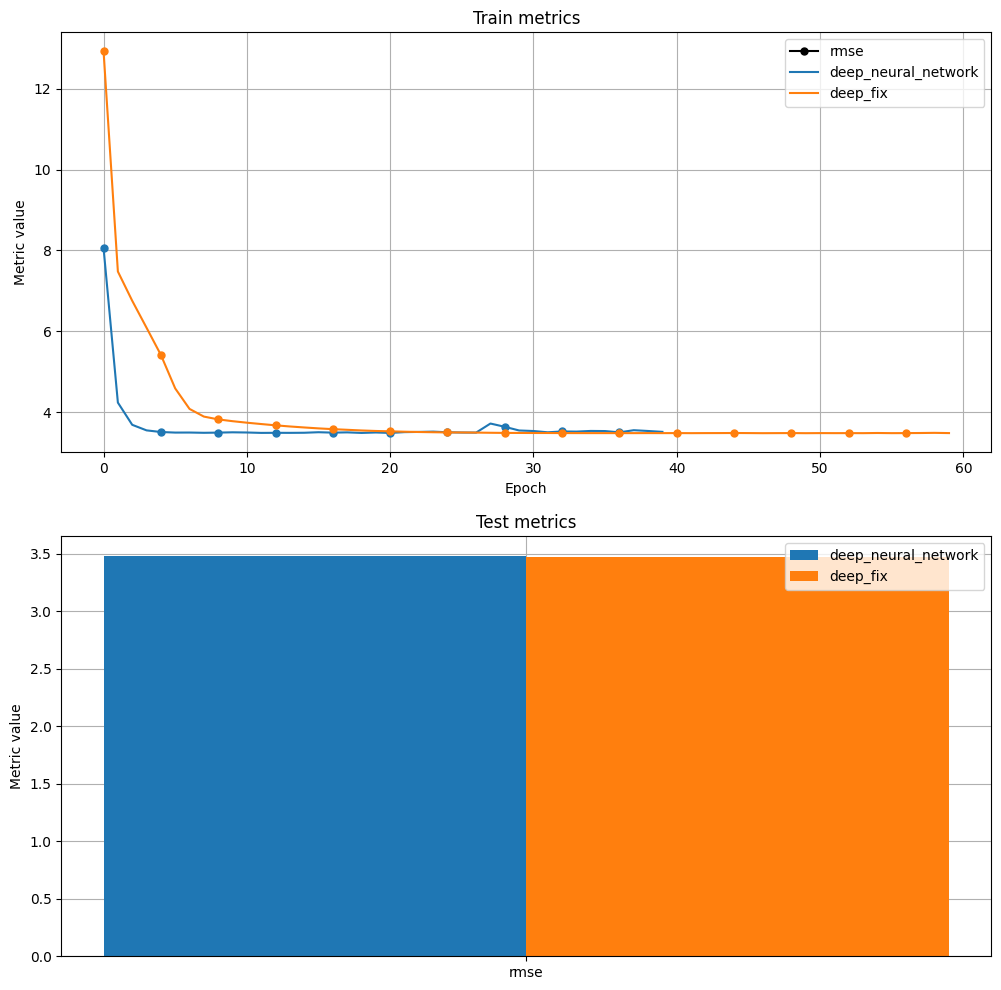

In [16]:
# --- 进阶 3：修复 DNN 的“暴躁”脾气 ---

# 我们把学习率从 0.01 降到 0.001 (慢工出细活)
settings_deep_fix = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,  # ⬇️ 调小这里，防止它乱跳
    number_epochs = 60,     # ⬇️ 因为步子小了，所以多给它一点时间(轮数)
    batch_size = 1000,
    input_features = ['TRIP_MILES', 'TRIP_MINUTES']
)

print("🔧 正在以更稳健的参数重新训练 DNN...")
model_deep_fix = create_deep_model(settings_deep_fix, metrics)
experiment_deep_fix = train_model('deep_fix', model_deep_fix, training_df, 'FARE', settings_deep_fix)

# 对比一下“暴躁版(deep_neural_network)”和“稳健版(deep_fix)”
print("\n对比修复前后的曲线：")
ml_edu.results.compare_experiment(
    [experiment_deep, experiment_deep_fix], 
    ['rmse'], 
    training_df, 
    training_df['FARE'].values
)

In [2]:
# --- 💀 终极压力测试：M4 Pro 烤机脚本 ---
import tensorflow as tf
import numpy as np
import time

# 1. 制造海量虚拟数据 (10万行，500个特征)
# 这会占用不少内存，模拟大数据吞吐
print("🌊 正在生成 100,000 条复杂数据，准备喂饱 GPU...")
num_samples = 100000
input_dim = 500
x_train = np.random.random((num_samples, input_dim)).astype('float32')
y_train = np.random.random((num_samples, 1)).astype('float32')

# 2. 搭建一个“巨型”神经网络
# 这种规模在实际线性回归里毫无必要，纯粹是为了费电
model_stress = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    # 第一层：4096 个神经元 (这是之前的 100 倍以上)
    tf.keras.layers.Dense(4096, activation='relu'), 
    # 第二层：4096 个神经元
    tf.keras.layers.Dense(4096, activation='relu'),
    # 第三层：4096 个神经元
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 3. 编译模型
model_stress.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

# 4. 开始暴力训练
# Batch Size = 8192 (一次塞进去 8000 条数据，塞满显存带宽)
print("🔥 GPU 压力测试开始！请观察活动监视器...")
start_time = time.time()

model_stress.fit(
    x_train, y_train, 
    epochs=10, 
    batch_size=8192,  # 这里的关键是 Batch Size 要大
    verbose=1
)

end_time = time.time()
print(f"🏁 测试结束！耗时: {end_time - start_time:.2f} 秒")

🌊 正在生成 100,000 条复杂数据，准备喂饱 GPU...
🔥 GPU 压力测试开始！请观察活动监视器...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 6858.4346
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 7511.7266
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - loss: 3557.4575
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - loss: 1167.2437
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - loss: 305.6750
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - loss: 105.5265
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - loss: 46.8553
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - loss: 30.1800
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - loss: 25.9833
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - loss: 24.4455
🏁 测试结束！耗时: 39.09 秒
